In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import random, os, collections, io
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# import matplotlib as pyplot

In [2]:
def make_train_and_test_sets():
    """Split the data into train and test sets and get the label classes."""
    train_examples, test_examples = [], []
    shuffler = random.Random()
    is_root = True
    for (dirname, subdirs, filenames) in tf.io.gfile.walk('/home/kalafreaky/code/data/'):
        # The root directory gives us the classes
        if is_root:
            subdirs = sorted(subdirs)
            classes = collections.OrderedDict(enumerate(subdirs))
            label_to_class = dict([(x, i) for i, x in enumerate(subdirs)])
            is_root = False
        # The sub directories give us the image files for training.
        else:
            filenames.sort()
            shuffler.shuffle(filenames)
            full_filenames = [os.path.join(dirname, f) for f in filenames]
            label = dirname.split('/')[-1] # '/' for linux and '\\' for windows
            label_class = label_to_class[label]
            examples = list(zip(full_filenames, [label_class] * len(filenames)))
            num_train = int(len(filenames) * 0.7)
            train_examples.extend(examples[:num_train])
            test_examples.extend(examples[num_train:])
    shuffler.shuffle(train_examples)
    shuffler.shuffle(test_examples)
    
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    for x in train_examples:
        tmp = Image.open(x[0]).resize((1116, 2011))
        data = np.asarray(tmp)
        x_train.append(data)
#         x_train.append(x[0])
        y_train.append([x[1]])
    for y in test_examples:
        tmp = Image.open(y[0]).resize((1116, 2011))
        data = np.asarray(tmp)
        x_test.append(data)
#         x_test.append(y[0])
        y_test.append([y[1]])
    return x_train, y_train, x_test, y_test, classes

In [3]:
TRAIN_SAMPLE, TRAIN_LABEL, TEST_SAMPLE, TEST_LABEL, CLASSES = make_train_and_test_sets()

In [4]:
# for i in TRAIN_SAMPLE:
#     print(i.shape)

# (840, 1400, 3) appears to be the minimum in both directions
# (1116, 2011, 3) appears to be the mode size

So here is the thing... The only conclusion I can come to is that the the images vary in size and that is causing the fit method to fail.

In [5]:
# Not sure this is necessary anymore.
TRAIN_LABEL = np.array(TRAIN_LABEL)
TEST_LABEL = np.array(TEST_LABEL)

Here is where we create the model that we are going to use. Keras is a lot more straightforward than old tensorflow.

In [6]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.summary()

In [7]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
# model.summary()

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

So here is the thing that gets weird. I can't get the model to train using the images and labels from our set. I decided to try and use a data set that is supplied in the tensorflow package. It seems to work fine.

In [9]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

Training the model

In [10]:
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.9710 - accuracy: 0.3393 - val_loss: 1.5609 - val_accuracy: 0.4266
Epoch 2/10
1563/1563 [==============================] - 21s 14ms/step - loss: 1.3854 - accuracy: 0.5006 - val_loss: 1.3250 - val_accuracy: 0.5235
Epoch 3/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.2193 - accuracy: 0.5695 - val_loss: 1.1934 - val_accuracy: 0.5814
Epoch 4/10
1563/1563 [==============================] - 21s 14ms/step - loss: 1.1100 - accuracy: 0.6116 - val_loss: 1.1125 - val_accuracy: 0.6134
Epoch 5/10
1563/1563 [==============================] - 21s 13ms/step - loss: 1.0310 - accuracy: 0.6406 - val_loss: 1.0606 - val_accuracy: 0.6334
Epoch 6/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.9530 - accuracy: 0.6674 - val_loss: 1.1052 - val_accuracy: 0.6321
Epoch 7/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.8966 - accuracy: 0.6876 - val_loss: 1.0575 -

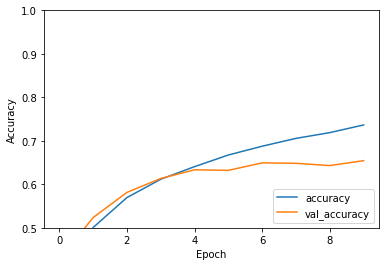

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [12]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print(test_acc)

313/313 - 1s - loss: 1.0455 - accuracy: 0.6544
0.6543999910354614
